# Superconducting pairing in QmeQ 

## BuilderSBase

This is an extension of QmeQ which allows for (superconducting) pairing terms to be inserted in the quantum dot Hamiltonian using the BuilderSBase class. This is done by specifying a new "pairing" attribute along with "hsingle" and "coulomb". The "indexing" attribute of the system is by default set to "charge", with charge states here denoting parity states, even for charge = 0 and odd for charge = 1. The number of "charge" states is thus always 2. To underline this change, the "symmetry" attribute is by default set to "parity". These are the only values of "indexing" and "symmetry" that are supported in this version (indexing = "charge", symmetry = "parity", default). 

The extension uses a modified version of the Pauli approach to solve for the current in the leads. The modified version takes into account that the electron number in the dot is not a good quantum number and the dot many-body states are parity states. As a result, transitions from many-body state $a$ to many-body state $b$ can be induced either by adding or by removing an electron to or from $a$ and in general:

$$
<b|d^\dagger |a> \neq 0 \quad \textrm{and} \quad <b|d|a> \neq 0.
$$

## BuilderManyBodyS

To avoid overlapping between the above transition matrix elements, one must only use the terms $\sim <b|d^\dagger |a> $ as the "Tba" input for the BuilderManyBodyS class. To underline this point, the relevant argument was renamed to "Tba_plus". 

Another difference in BuilderManyBodyS compared to BuilderManyBody is that the array "Na" is now expected to contain the parity of the states corresponding to "Ea" (0 and 1 for even and odd parity respectively).


## General notes

Note 1: For the superconducting terms one should only pass the coefficients $D$ for terms of the form $Dd^\dagger_m d^\dagger_n$ - which add electrons to the dot - as argument to BuilderSBase. The hermitian conjugates of these terms ($D^*d_n d_m$) are inserted automatically. It is also expected that $m<n$.

Note 2: Only the Pauli approach has been implemented, there is no support for the rest of the approaches

Note 3: BuilderSBase is a child class of BuilderBase and inherits its methods. Nevertheless, it is not guaranteed that all BuilderBase methods work as intended for a BuilderSBase object.

Class methods of BuilderBase that have been checked and work or have been re-implemented for BuilderSBase: add(), change(), get_kerntype(), get_indexing(), get_dband(), print_state(), print_all_states(), 

Class methods of BuilderBase that are not guarenteed to work as expected: set_kerntype(), set_indexing(), set_dband(self), get_phi0(), get_phi1(), sort_eigenstates(), remove_coherences(), remove_states(), use_all_states(), remove_fock_states().
Instead of using the setters, it is recommended to re-build the system. phi0 can be reached through "system.phi0". The eigenstates are sorted by parity (first even then odd). In each parity sector they are sorted by energy. Coherences are not relevant for the Pauli approach.

## Examples - Tests

### 1 dot stability diagram
#### Dot Hamiltonian (1 spinful orbital) with proximity induced superconducting pairing:

$$ 
H = \sum_\sigma \epsilon_\sigma d_\sigma^\dagger d_\sigma + (\Omega d^\dagger_\uparrow d_\downarrow + H.c.) 
+ U d^\dagger_\uparrow d^\dagger_\downarrow d_\downarrow d_\uparrow  + H_D,
$$
where:
$$
H_D = -Dd^\dagger_\uparrow d^\dagger_\downarrow + H.c.
$$

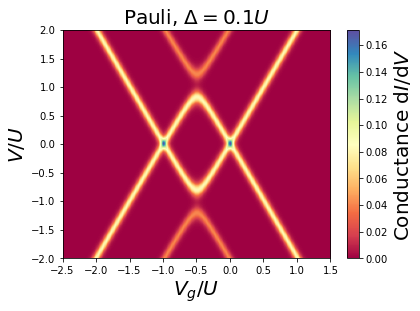

In [2]:
# Prerequisites
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
import qmeq

#---------------------------------------------------

# Quantum dot parameters
vgate, bfield, omega, U = 0.0, 0.0, 0.0, 20.0
D = 0.1*U
# Lead parameters
vbias, temp, dband = 0.5, 0.5, 60.0
# Tunneling amplitudes
gam = 0.5
t0 = np.sqrt(gam/(2*np.pi))

#---------------------------------------------------

nsingle = 2
# 0 is up, 1 is down
hsingle = {(0,0): vgate+bfield/2,
           (1,1): vgate-bfield/2,
           (0,1): omega}

coulomb = {(0,1,1,0): U}

pairing = {(0,1): -D}

tleads = {(0,0): t0, # L, up   <-- up
          (1,0): t0, # R, up   <-- up
          (2,1): t0, # L, down <-- down
          (3,1): t0} # R, down <-- down
                     # lead label, lead spin <-- level spin

nleads = 4
#        L,up        R,up         L,down      R,down
mulst = {0: vbias/2, 1: -vbias/2, 2: vbias/2, 3: -vbias/2}
tlst =  {0: temp,    1: temp,     2: temp,    3: temp}

system = qmeq.BuilderSBase(nsingle=nsingle, hsingle=hsingle, coulomb=coulomb, pairing = pairing,
                         nleads=nleads, tleads=tleads, mulst=mulst, tlst=tlst, dband=dband,
                         kerntype="Pauli")


def stab_calc(system, bfield, vlst, vglst, dV=0.0001):
    vpnt, vgpnt = vlst.shape[0], vglst.shape[0]
    stab = np.zeros((vpnt, vgpnt))
    stab_cond = np.zeros((vpnt, vgpnt))
    #
    for j1 in range(vgpnt):
        system.change(hsingle={(0,0):vglst[j1]+bfield/2,
                               (1,1):vglst[j1]-bfield/2})
        system.solve(masterq=False)
        for j2 in range(vpnt):
            system.change(mulst={0: vlst[j2]/2, 1: -vlst[j2]/2,
                                 2: vlst[j2]/2, 3: -vlst[j2]/2})
            system.solve(qdq=False)
            stab[j1, j2] = (system.current[0]
                          + system.current[2])
            #
            system.add(mulst={0: dV/2, 1: -dV/2,
                              2: dV/2, 3: -dV/2})
            system.solve(qdq=False)
            stab_cond[j1, j2] = (system.current[0]
                               + system.current[2]
                               - stab[j1, j2])/dV
    #
    return stab, stab_cond

def stab_plot(stab_cond, vlst, vglst, U, gam, title, fname='fig.pdf'):
    (xmin, xmax, ymin, ymax) = np.array([vglst[0], vglst[-1],
                                         vlst[0], vlst[-1]])/U
    fig = plt.figure(figsize=(6,4.2))
    p = plt.subplot(1, 1, 1)
    p.set_xlabel('$V_{g}/U$', fontsize=20)
    p.set_ylabel('$V/U$', fontsize=20)
    p.set_title(title, fontsize=20)
    p_im = plt.imshow(stab_cond.T, extent=[xmin, xmax, ymin, ymax],
                                   aspect='auto',
                                   origin='lower',
                                   cmap=plt.get_cmap('Spectral'))
    cbar = plt.colorbar(p_im)
    cbar.set_label('Conductance $\mathrm{d}I/\mathrm{d}V$', fontsize=20)
    fig.savefig(fname, bbox_inches='tight', dpi=100, pad_inches=0.0)
    plt.show()

vpnt, vgpnt = 201, 201
vlst = np.linspace(-2*U, 2*U, vpnt)
vglst = np.linspace(-2.5*U, 1.5*U, vgpnt)
stab, stab_cond = stab_calc(system, bfield, vlst, vglst)
stab_plot(stab_cond, vlst, vglst, U, gam, 'Pauli, $\Delta=0.1U$', 'stab.pdf')


### 2 parallel coupled dots I-Vg for small bias

#### DQD Hamiltonian (1 spinful orbital/dot) with proximity induced superconducting pairing:

The Hamiltonian of the DQD system is: 

$$ H = \sum_{j,\sigma} \epsilon_j n_{j\sigma}  -t \sum_\sigma ( d_{1\sigma}^\dagger d_{2\sigma} + H.C.)
+ \sum_j U_{jj} n_{j\uparrow} n_{j\downarrow} + U_{12} \sum_{\sigma,\sigma'} n_{1\sigma} n_{2 \sigma'} + H_D,
$$

$$
H_D = - \sum_j D_{jj}  d_{j \uparrow}^\dagger d_{j \downarrow}^\dagger  
- D_{12} ( d_{1\uparrow}^\dagger d_{2\downarrow}^\dagger - d_{1\downarrow}^\dagger d_{2\uparrow}^\dagger ) + H.C.
$$

where $n_{j\sigma} = d_{j\sigma}^\dagger d_{j\sigma}$ and $j=1,2$. 



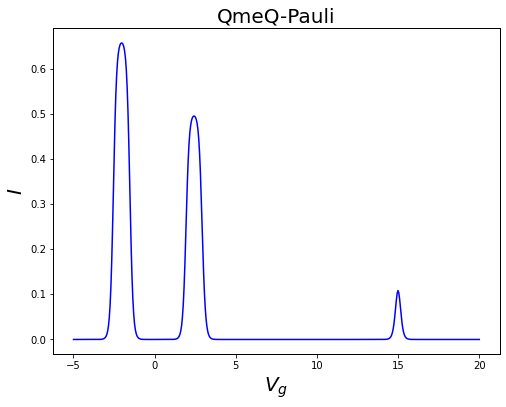

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import qmeq

# Quantum dot parameters in meV
vgate = 0.

e1, e2 = 0., 0.0001  # onsite

t = 2.  # hopping
U11 = 15.0  # intradot Coulomb
U12 = 1.5  # interdot Coulomb

D11 = 0.
D22 = D11
D12 = D11/2.

# Lead parameters in meV
vbias = 1.
temp = 0.1
dband = 60.0
# Tunneling amplitudes in meV
gamL, gamR = 1., 1.
tL, tR = np.sqrt(gamL / (2 * np.pi)), np.sqrt(gamR / (2 * np.pi))

nsingle = 4  # number of single-particle states

# 0 is up, 1 is down
hsingle = {(0, 0): e1 - vgate, (1, 1): e1 - vgate, (2, 2): e2 - vgate, (3, 3): e2 - vgate,
           (0, 2): -t, (1, 3): -t}

coulomb = {(0, 1, 1, 0): U11, (2, 3, 3, 2): U11,  # intra
           (0, 2, 2, 0): U12, (0, 3, 3, 0): U12, (1, 2, 2, 1): U12, (1, 3, 3, 1): U12}

pairing = {(0, 1): -D11, (2, 3): -D22, (0, 3): -D12, (1,2): D12 }

# The coupling matrix has indices(lead−spin , level)
tleads = {(0, 0): tL, (0, 2): tL, (1, 0): tR, (1, 2): tR,  # spin up fpr L and R
          (2, 1): tL, (2, 3): tL, (3, 1): tR, (3, 3): tR}  # spin down fpr L and R

nleads = 4

#        L,up        R,up         L,down      R,down
mulst = {0: vbias / 2, 1: -vbias / 2, 2: vbias / 2, 3: -vbias / 2}
tlst = {0: temp, 1: temp, 2: temp, 3: temp}

system = qmeq.BuilderSBase(nsingle=nsingle, hsingle=hsingle, coulomb=coulomb, pairing = pairing,
                         nleads=nleads, tleads=tleads, mulst=mulst, tlst=tlst, dband=dband,
                         kerntype="Pauli")

####### plot current vs vgate

vgate_start = -5.
vgate_stop = 20.
vgate_nsteps = 500
vgate_values = np.linspace(vgate_start, vgate_stop, vgate_nsteps)

Itoplot = []

for jj in range(len(vgate_values)):
    system.change(hsingle={(0, 0): e1 - vgate_values[jj], (1, 1): e1 - vgate_values[jj], (2, 2): e2 - vgate_values[jj],
                           (3, 3): e2 - vgate_values[jj],
                           (0, 2): -t, (1, 3): -t})
    system.solve()
    Itoplot.append(system.current[0])

fig = plt.figure(figsize=(8, 6))  # ,     ,dpi=600)#

ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure

# change the thickness of all the subplot axes
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.)

ax.plot(vgate_values, Itoplot, c="blue")

ax.set_ylabel('$I $', fontsize=20)
ax.set_xlabel(r"$ V_g $", fontsize=20)

ax.set_title('QmeQ-Pauli', fontsize=20)

# ax.set_ylim(-0.01,0.4)

plt.show()

### 2 parallel coupled dots stability diagram

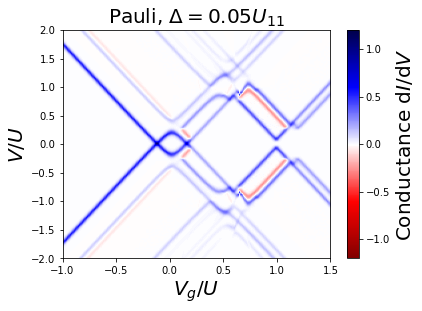

In [13]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
import qmeq
import matplotlib.colors as mcolors # normalization of data for plotting

# Quantum dot parameters in meV
vgate = 0.

e1, e2 = 0., 0.0001  # onsite

t = 2.  # hopping
U11 = 15.0  # intradot Coulomb
U12 = 1.5  # interdot Coulomb
D11 = 0.05*U11
D22 = D11
D12 = D11 / 2.

# Lead parameters in meV
vbias = 0.
temp = 0.15
dband = 60.0
# Tunneling amplitudes in meV
gamL, gamR = 0.5, 0.5
tL, tR = np.sqrt(gamL / (2 * np.pi)), np.sqrt(gamR / (2 * np.pi))

nsingle = 4  # number of single-particle states

# 0 is up, 1 is down
hsingle = {(0, 0): e1 - vgate, (1, 1): e1 - vgate, (2, 2): e2 - vgate, (3, 3): e2 - vgate,
           (0, 2): -t, (1, 3): -t}

coulomb = {(0, 1, 1, 0): U11, (2, 3, 3, 2): U11,  # intra
           (0, 2, 2, 0): U12, (0, 3, 3, 0): U12, (1, 2, 2, 1): U12, (1, 3, 3, 1): U12}

pairing = {(0, 1): -D11, (2, 3): -D22, (0, 3): -D12, (1, 2): D12}

# The coupling matrix has indices(lead−spin , level)
tleads = {(0, 0): tL, (0, 2): tL, (1, 0): tR, (1, 2): tR,  # spin up fpr L and R
          (2, 1): tL, (2, 3): tL, (3, 1): tR, (3, 3): tR}  # spin down fpr L and R

nleads = 4

#        L,up        R,up         L,down      R,down
mulst = {0: vbias / 2, 1: -vbias / 2, 2: vbias / 2, 3: -vbias / 2}
tlst = {0: temp, 1: temp, 2: temp, 3: temp}

system = qmeq.BuilderSBase(nsingle=nsingle, hsingle=hsingle, coulomb=coulomb, pairing = pairing,
                         nleads=nleads, tleads=tleads, mulst=mulst, tlst=tlst, dband=dband,
                         kerntype="Pauli")

def stab_calc(system, bfield, vlst, vglst, dV=0.0001):
    vpnt, vgpnt = vlst.shape[0], vglst.shape[0]
    stab = np.zeros((vpnt, vgpnt))
    stab_cond = np.zeros((vpnt, vgpnt))
    #
    for j1 in range(vgpnt):
        system.change(hsingle = {(0, 0): e1-vglst[j1], (1, 1): e1-vglst[j1], (2, 2): e2-vglst[j1], (3, 3): e2-vglst[j1],
                              (0, 2): -t,    (1,3): -t })
        system.solve(masterq=False)
        for j2 in range(vpnt):
            system.change(mulst={0: vlst[j2]/2, 1: -vlst[j2]/2,
                                 2: vlst[j2]/2, 3: -vlst[j2]/2})
            system.solve(qdq=False)
            stab[j1, j2] = (system.current[0]
                          + system.current[2])
            #
            system.add(mulst={0: dV/2, 1: -dV/2,
                              2: dV/2, 3: -dV/2})
            system.solve(qdq=False)
            stab_cond[j1, j2] = (system.current[0]
                               + system.current[2]
                               - stab[j1, j2])/dV
    #
    return stab, stab_cond

def stab_plot(stab_cond, vlst, vglst, U, gam, title, fname='fig.pdf'):
    (xmin, xmax, ymin, ymax) = np.array([vglst[0], vglst[-1],
                                         vlst[0], vlst[-1]])/U
    fig = plt.figure(figsize=(6,4.2))
    p = plt.subplot(1, 1, 1)
    p.set_xlabel('$V_{g}/U$', fontsize=20)
    p.set_ylabel('$V/U$', fontsize=20)
    p.set_title(title, fontsize=20)
    offset = mcolors.TwoSlopeNorm( vcenter=0., vmax=1.2, vmin=-1.2 ) #   )#
    p_im = plt.imshow(stab_cond.T, extent=[xmin, xmax, ymin, ymax], norm = offset,
                                   aspect='auto',
                                   origin='lower',
                                   cmap=plt.get_cmap('seismic_r'))
    cbar = plt.colorbar(p_im)
    cbar.set_label('Conductance $\mathrm{d}I/\mathrm{d}V$', fontsize=20)
    fig.savefig(fname, bbox_inches='tight', dpi=100, pad_inches=0.0)
    plt.show()

vpnt, vgpnt = 201, 201
vlst = np.linspace(-2*U11, 2*U11, vpnt)
vglst = np.linspace(-1.*U11, 1.5*U11, vgpnt)
stab, stab_cond = stab_calc(system, 0., vlst, vglst)
stab_plot(stab_cond, vlst, vglst, U11, gamL, 'Pauli, $\Delta=0.05U_{11}$', 'stab.pdf')

## Test class BuilderManyBodyS
Here we use sqmeq.py to obtain the input for BuilderManyBodyS
### 1 dot stab diagram

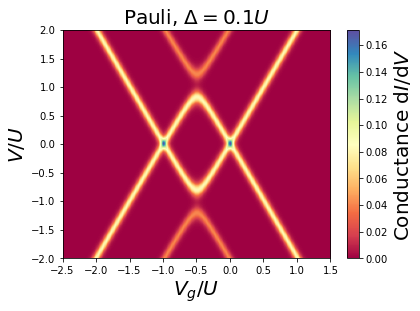

In [14]:
# Prerequisites
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
import qmeq
import sqmeq


#---------------------------------------------------

# Quantum dot parameters
vgate, bfield, omega, U = 0.0, 0.0, 0.0, 20.0
D = 0.1*U
# Lead parameters
vbias, temp, dband = 0.5, 0.5, 60.0
# Tunneling amplitudes
gam = 0.5
t0 = np.sqrt(gam/(2*np.pi))

#---------------------------------------------------

nsingle = 2
# 0 is up, 1 is down
hsingle = {(0,0): vgate+bfield/2,
           (1,1): vgate-bfield/2,
           (0,1): omega}

coulomb = {(0,1,1,0): U}

pairing = {(0,1): -D}

tleads = {(0,0): t0, # L, up   <-- up
          (1,0): t0, # R, up   <-- up
          (2,1): t0, # L, down <-- down
          (3,1): t0} # R, down <-- down
                     # lead label, lead spin <-- level spin

nleads = 4
#        L,up        R,up         L,down      R,down
mulst = {0: vbias/2, 1: -vbias/2, 2: vbias/2, 3: -vbias/2}
tlst =  {0: temp,    1: temp,     2: temp,    3: temp}

system = sqmeq.SBuilder(nsingle, hsingle, coulomb,
                           nleads, tleads, mulst, tlst, dband, pairing=pairing)

def stab_calc(system, bfield, vlst, vglst, dV=0.0001):
    vpnt, vgpnt = vlst.shape[0], vglst.shape[0]
    stab = np.zeros((vpnt, vgpnt))
    stab_cond = np.zeros((vpnt, vgpnt))
    #
    for j1 in range(vgpnt):
        system.change_ham(hsingle={(0,0):vglst[j1]+bfield/2,
                               (1,1):vglst[j1]-bfield/2})
        system.diag_ham()
        system.get_mbstates_parities()
        system.rotate_Tpm()
        systemmb = qmeq.BuilderManyBodyS(Ea = system.mbvals, Na = system.mbstates_parities,
                                     Tba_plus = system.Tplus,
                                     mulst=mulst, tlst=tlst, dband=dband)
        for j2 in range(vpnt):
            systemmb.change(mulst={0: vlst[j2]/2, 1: -vlst[j2]/2,
                                 2: vlst[j2]/2, 3: -vlst[j2]/2})
            systemmb.solve(qdq=False, rotateq=False, masterq=True, currentq=True)
            stab[j1, j2] = (systemmb.current[0]
                          + systemmb.current[2])
            #
            systemmb.add(mulst={0: dV/2, 1: -dV/2,
                              2: dV/2, 3: -dV/2})
            systemmb.solve(qdq=False, rotateq=False, masterq=True, currentq=True)
            stab_cond[j1, j2] = (systemmb.current[0]
                               + systemmb.current[2]
                               - stab[j1, j2])/dV
    #
    return stab, stab_cond

def stab_plot(stab_cond, vlst, vglst, U, gam, title, fname='fig.pdf'):
    (xmin, xmax, ymin, ymax) = np.array([vglst[0], vglst[-1],
                                         vlst[0], vlst[-1]])/U
    fig = plt.figure(figsize=(6,4.2))
    p = plt.subplot(1, 1, 1)
    p.set_xlabel('$V_{g}/U$', fontsize=20)
    p.set_ylabel('$V/U$', fontsize=20)
    p.set_title(title, fontsize=20)
    p_im = plt.imshow(stab_cond.T, extent=[xmin, xmax, ymin, ymax],
                                   aspect='auto',
                                   origin='lower',
                                   cmap=plt.get_cmap('Spectral'))
    cbar = plt.colorbar(p_im)
    cbar.set_label('Conductance $\mathrm{d}I/\mathrm{d}V$', fontsize=20)
    fig.savefig(fname, bbox_inches='tight', dpi=100, pad_inches=0.0)
    plt.show()

vpnt, vgpnt = 201, 201
vlst = np.linspace(-2*U, 2*U, vpnt)
vglst = np.linspace(-2.5*U, 1.5*U, vgpnt)
stab, stab_cond = stab_calc(system, bfield, vlst, vglst)
stab_plot(stab_cond, vlst, vglst, U, gam, 'Pauli, $\Delta=0.1U$', 'stab02T05.pdf')

### 2 parallel coupled dots I-Vg for small bias

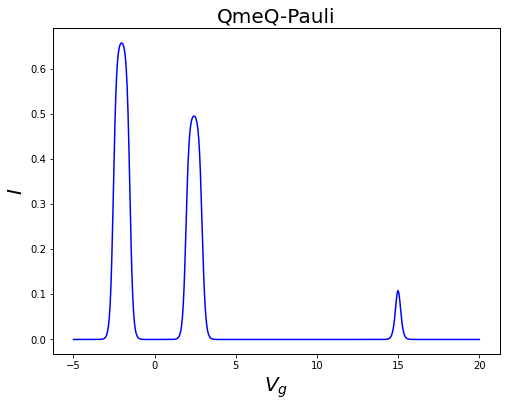

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

import qmeq
import sqmeq

# Quantum dot parameters in meV
vgate = 0.

e1, e2 = 0., 0.0001  # onsite

t = 2.  # hopping
U11 = 15.0  # intradot Coulomb
U12 = 1.5  # interdot Coulomb

D11 = 0.
D22 = D11
D12 = D11/2.

# Lead parameters in meV
vbias = 1.
temp = 0.1
dband = 60.0
# Tunneling amplitudes in meV
gamL, gamR = 1., 1.
tL, tR = np.sqrt(gamL / (2 * np.pi)), np.sqrt(gamR / (2 * np.pi))

nsingle = 4  # number of single-particle states

# 0 is up, 1 is down
hsingle = {(0, 0): e1 - vgate, (1, 1): e1 - vgate, (2, 2): e2 - vgate, (3, 3): e2 - vgate,
           (0, 2): -t, (1, 3): -t}

coulomb = {(0, 1, 1, 0): U11, (2, 3, 3, 2): U11,  # intra
           (0, 2, 2, 0): U12, (0, 3, 3, 0): U12, (1, 2, 2, 1): U12, (1, 3, 3, 1): U12}

pairing = {(0, 1): -D11, (2, 3): -D22, (0, 3): -D12, (1,2): D12 }

# The coupling matrix has indices(lead−spin , level)
tleads = {(0, 0): tL, (0, 2): tL, (1, 0): tR, (1, 2): tR,  # spin up fpr L and R
          (2, 1): tL, (2, 3): tL, (3, 1): tR, (3, 3): tR}  # spin down fpr L and R

nleads = 4

#        L,up        R,up         L,down      R,down
mulst = {0: vbias / 2, 1: -vbias / 2, 2: vbias / 2, 3: -vbias / 2}
tlst = {0: temp, 1: temp, 2: temp, 3: temp}

system = sqmeq.SBuilder(nsingle=nsingle, hsingle=hsingle, coulomb=coulomb, pairing = pairing,
                         nleads=nleads, tleads=tleads, mulst=mulst, tlst=tlst, dband=dband,
                         kerntype="Pauli")

####### plot current vs vgate

vgate_start = -5.
vgate_stop = 20.
vgate_nsteps = 500
vgate_values = np.linspace(vgate_start, vgate_stop, vgate_nsteps)

Itoplot = []

for jj in range(len(vgate_values)):
    system.change_ham(hsingle={(0, 0): e1 - vgate_values[jj], (1, 1): e1 - vgate_values[jj], (2, 2): e2 - vgate_values[jj],
                           (3, 3): e2 - vgate_values[jj],
                           (0, 2): -t, (1, 3): -t})
    system.diag_ham()
    system.get_mbstates_parities()
    system.rotate_Tpm()
    systemmb = qmeq.BuilderManyBodyS(Ea = system.mbvals, Na = system.mbstates_parities,
                                     Tba_plus = system.Tplus,
                                     mulst=mulst, tlst=tlst, dband=dband)
    systemmb.solve(qdq=False, rotateq=False, masterq=True, currentq=True)
    Itoplot.append(systemmb.current[0])

fig = plt.figure(figsize=(8, 6))  # ,     ,dpi=600)#

ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure

# change the thickness of all the subplot axes
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.)

ax.plot(vgate_values, Itoplot, c="blue")

ax.set_ylabel('$I $', fontsize=20)
ax.set_xlabel(r"$ V_g $", fontsize=20)

ax.set_title('QmeQ-Pauli', fontsize=20)

# ax.set_ylim(-0.01,0.4)

plt.show()

### 2 parallel coupled dots stability diagram

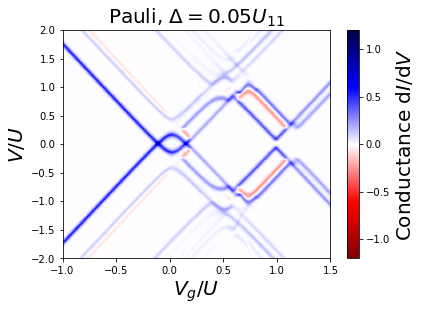

In [16]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
import qmeq
import matplotlib.colors as mcolors # normalization of data for plotting
import sqmeq

# Quantum dot parameters in meV
vgate = 0.

e1, e2 = 0., 0.0001  # onsite

t = 2.  # hopping
U11 = 15.0  # intradot Coulomb
U12 = 1.5  # interdot Coulomb
D11 = 1.
D22 = D11
D12 = D11 / 2.

# Lead parameters in meV
vbias = 0.
temp = 0.15
dband = 60.0
# Tunneling amplitudes in meV
gamL, gamR = 0.5, 0.5
tL, tR = np.sqrt(gamL / (2 * np.pi)), np.sqrt(gamR / (2 * np.pi))

nsingle = 4  # number of single-particle states

# 0 is up, 1 is down
hsingle = {(0, 0): e1 - vgate, (1, 1): e1 - vgate, (2, 2): e2 - vgate, (3, 3): e2 - vgate,
           (0, 2): -t, (1, 3): -t}

coulomb = {(0, 1, 1, 0): U11, (2, 3, 3, 2): U11,  # intra
           (0, 2, 2, 0): U12, (0, 3, 3, 0): U12, (1, 2, 2, 1): U12, (1, 3, 3, 1): U12}

pairing = {(0, 1): -D11, (2, 3): -D22, (0, 3): -D12, (1, 2): D12}

# The coupling matrix has indices(lead−spin , level)
tleads = {(0, 0): tL, (0, 2): tL, (1, 0): tR, (1, 2): tR,  # spin up fpr L and R
          (2, 1): tL, (2, 3): tL, (3, 1): tR, (3, 3): tR}  # spin down fpr L and R

nleads = 4

#        L,up        R,up         L,down      R,down
mulst = {0: vbias / 2, 1: -vbias / 2, 2: vbias / 2, 3: -vbias / 2}
tlst = {0: temp, 1: temp, 2: temp, 3: temp}

system = sqmeq.SBuilder(nsingle=nsingle, hsingle=hsingle, coulomb=coulomb, pairing = pairing,
                         nleads=nleads, tleads=tleads, mulst=mulst, tlst=tlst, dband=dband,
                         kerntype="Pauli")

def stab_calc(system, bfield, vlst, vglst, dV=0.0001):
    vpnt, vgpnt = vlst.shape[0], vglst.shape[0]
    stab = np.zeros((vpnt, vgpnt))
    stab_cond = np.zeros((vpnt, vgpnt))
    #
    for j1 in range(vgpnt):
        system.change_ham(hsingle = {(0, 0): e1-vglst[j1], (1, 1): e1-vglst[j1], (2, 2): e2-vglst[j1], (3, 3): e2-vglst[j1],
                              (0, 2): -t,    (1,3): -t })
        system.diag_ham()
        system.get_mbstates_parities()
        system.rotate_Tpm()
        systemmb = qmeq.BuilderManyBodyS(Ea = system.mbvals, Na = system.mbstates_parities,
                                         Tba_plus = system.Tplus,
                                         mulst=mulst, tlst=tlst, dband=dband)
        for j2 in range(vpnt):
            systemmb.change(mulst={0: vlst[j2]/2, 1: -vlst[j2]/2,
                                 2: vlst[j2]/2, 3: -vlst[j2]/2})
            systemmb.solve(qdq=False)
            stab[j1, j2] = (systemmb.current[0]
                          + systemmb.current[2])
            #
            systemmb.add(mulst={0: dV/2, 1: -dV/2,
                              2: dV/2, 3: -dV/2})
            systemmb.solve(qdq=False)
            stab_cond[j1, j2] = (systemmb.current[0]
                               + systemmb.current[2]
                               - stab[j1, j2])/dV
    #
    return stab, stab_cond

def stab_plot(stab_cond, vlst, vglst, U, gam, title, fname='fig.pdf'):
    (xmin, xmax, ymin, ymax) = np.array([vglst[0], vglst[-1],
                                         vlst[0], vlst[-1]])/U
    fig = plt.figure(figsize=(6,4.2))
    p = plt.subplot(1, 1, 1)
    p.set_xlabel('$V_{g}/U$', fontsize=20)
    p.set_ylabel('$V/U$', fontsize=20)
    p.set_title(title, fontsize=20)
    offset = mcolors.TwoSlopeNorm( vcenter=0., vmax=1.2, vmin=-1.2 ) #   )#
    p_im = plt.imshow(stab_cond.T, extent=[xmin, xmax, ymin, ymax], norm = offset,
                                   aspect='auto',
                                   origin='lower',
                                   cmap=plt.get_cmap('seismic_r'))
    cbar = plt.colorbar(p_im)
    cbar.set_label('Conductance $\mathrm{d}I/\mathrm{d}V$', fontsize=20)
    fig.savefig(fname, bbox_inches='tight', dpi=100, pad_inches=0.0)
    plt.show()

vpnt, vgpnt = 201, 201
vlst = np.linspace(-2*U11, 2*U11, vpnt)
vglst = np.linspace(-1.*U11, 1.5*U11, vgpnt)
stab, stab_cond = stab_calc(system, 0., vlst, vglst)
stab_plot(stab_cond, vlst, vglst, U11, gamL, 'Pauli, $\Delta=0.05U_{11}$', 'stab.pdf')

## Comparing numerical values for BuilderSBase and BuilderManyBodyS


In [18]:
# Prerequisites
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
import qmeq
import sqmeq

#---------------------------------------------------

# Quantum dot parameters
vgate, bfield, omega, U = 0.0, 0.0, 0.0, 20.0
D = 0.1*U
# Lead parameters
vbias, temp, dband = 0.5, 0.5, 60.0
# Tunneling amplitudes
gam = 0.5
t0 = np.sqrt(gam/(2*np.pi))

#---------------------------------------------------

nsingle = 2
# 0 is up, 1 is down
hsingle = {(0,0): vgate+bfield/2,
           (1,1): vgate-bfield/2,
           (0,1): omega}

coulomb = {(0,1,1,0): U}

pairing = {(0,1): -D}

tleads = {(0,0): t0, # L, up   <-- up
          (1,0): t0, # R, up   <-- up
          (2,1): t0, # L, down <-- down
          (3,1): t0} # R, down <-- down
                     # lead label, lead spin <-- level spin

nleads = 4
#        L,up        R,up         L,down      R,down
mulst = {0: vbias/2, 1: -vbias/2, 2: vbias/2, 3: -vbias/2}
tlst =  {0: temp,    1: temp,     2: temp,    3: temp}


########################################################################################################################
system1 = qmeq.BuilderSBase(nsingle=nsingle, hsingle=hsingle, coulomb=coulomb, pairing = pairing,
                         nleads=nleads, tleads=tleads, mulst=mulst, tlst=tlst, dband=dband,
                         kerntype="Pauli")
system1.solve()
########################################################################################################################
system2 = sqmeq.SBuilder(nsingle=nsingle, hsingle=hsingle, coulomb=coulomb, pairing = pairing,
                         nleads=nleads, tleads=tleads, mulst=mulst, tlst=tlst, dband=dband,
                         kerntype="Pauli")
system2.diag_ham()
system2.get_mbstates_parities()
system2.rotate_Tpm()
system2mb = qmeq.BuilderManyBodyS(Ea = system2.mbvals, Na = system2.mbstates_parities,
                                         Tba_plus = system2.Tplus,
                                         mulst=mulst, tlst=tlst, dband=dband)
system2mb.solve(qdq=False)
########################################################################################################################
print()
print(system1.current)
print(system2mb.current)


########################################################################################################################
system1.change(mulst = {0: vbias/2 + 1, 1: -vbias/2 -1, 2: vbias/2 + 1, 3: -vbias/2 -1})
system1.solve()
########################################################################################################################
system2.change(mulst = {0: vbias/2 + 1, 1: -vbias/2 -1, 2: vbias/2 + 1, 3: -vbias/2 -1})
system2mb.change(mulst = {0: vbias/2 + 1, 1: -vbias/2 -1, 2: vbias/2 + 1, 3: -vbias/2 -1})
system2mb.solve(qdq=False)
########################################################################################################################
print()
print(system1.current)
print(system2mb.current)


########################################################################################################################
system1.change(tlst =  {0: temp+0.1,    1: temp+0.1,     2: temp+0.1,    3: temp+0.1})
system1.solve()
########################################################################################################################
system2.change(tlst =  {0: temp+0.1,    1: temp+0.1,     2: temp+0.1,    3: temp+0.1})
system2mb.change(tlst =  {0: temp+0.1,    1: temp+0.1,     2: temp+0.1,    3: temp+0.1})
system2mb.solve(qdq=False)
########################################################################################################################
print()
print(system1.current)
print(system2mb.current)


########################################################################################################################
system1.change(hsingle = {(0,0): vgate+bfield/2+0.1, (1,1): vgate-bfield/2-0.1, (0,1): 0.1})
system1.solve()
########################################################################################################################
system2.change_ham(hsingle = {(0,0): vgate+bfield/2+0.1, (1,1): vgate-bfield/2-0.1, (0,1): 0.1})
system2.diag_ham()
system2.get_mbstates_parities()
system2.rotate_Tpm()
system2mb = qmeq.BuilderManyBodyS(Ea = system2.mbvals, Na = system2.mbstates_parities,
                                         Tba_plus = system2.Tplus,
                                         mulst=system2mb.mulst, tlst=system2mb.tlst, dband=system2mb.dband)
system2mb.solve(qdq=False)
########################################################################################################################
print()
print(system1.current)
print(system2mb.current)


########################################################################################################################
system1.change(coulomb = {(0,1,1,0): U-1})
system1.solve()
########################################################################################################################
system2.change_ham(coulomb = {(0,1,1,0): U-1})
system2.diag_ham()
system2.get_mbstates_parities()
system2.rotate_Tpm()
system2mb = qmeq.BuilderManyBodyS(Ea = system2.mbvals, Na = system2.mbstates_parities,
                                         Tba_plus = system2.Tplus,
                                         mulst=system2mb.mulst, tlst=system2mb.tlst, dband=system2mb.dband)
system2mb.solve(qdq=False)
########################################################################################################################
print()
print(system1.current)
print(system2mb.current)


########################################################################################################################
system1.change(pairing = {(0,1): -D-0.5})
system1.solve()
########################################################################################################################
system2.change_ham(pairing = {(0,1): -D-0.5})
system2.diag_ham()
system2.get_mbstates_parities()
system2.rotate_Tpm()
system2mb = qmeq.BuilderManyBodyS(Ea = system2.mbvals, Na = system2.mbstates_parities,
                                         Tba_plus = system2.Tplus,
                                         mulst=system2mb.mulst, tlst=system2mb.tlst, dband=system2mb.dband)
system2mb.solve(qdq=False)
########################################################################################################################
print()
print(system1.current)
print(system2mb.current)


[ 0.04192393 -0.04192393  0.04192393 -0.04192393]
[ 0.04192393 -0.04192393  0.04192393 -0.04192393]

[ 0.14250017 -0.14250017  0.14250017 -0.14250017]
[ 0.14250017 -0.14250017  0.14250017 -0.14250017]

[ 0.13123229 -0.13123229  0.13123229 -0.13123229]
[ 0.13123229 -0.13123229  0.13123229 -0.13123229]

[ 0.12510394 -0.12510394  0.13598071 -0.13598071]
[ 0.12510394 -0.12510394  0.13598071 -0.13598071]

[ 0.12505553 -0.12505553  0.1360478  -0.1360478 ]
[ 0.12505553 -0.12505553  0.1360478  -0.1360478 ]

[ 0.12394922 -0.12394922  0.13638123 -0.13638123]
[ 0.12394922 -0.12394922  0.13638123 -0.13638123]
